<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li>

#  Прогнозирование заказов такси


Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install statsmodels
!pip install sklearn
!pip install lightgbm
!pip install catboost

In [2]:
import time 
import warnings

import pandas as pd 
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from numpy.random import RandomState
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

warnings.filterwarnings('ignore')

STATE = RandomState(12345)

### Загрузка данных

In [3]:
try: 
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])

### Изучение данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


### Ресемплирование данных

Проверим, в хронологическом ли порядке расположены даты и время

In [6]:
data.index.is_monotonic_increasing

True

Выполним ресемплирование данных по одному часу

In [7]:
data = data.resample('1H').sum()

In [8]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<b> Промежуточный вывод:</b>
Данные были загружены, изучены, проверены на монотонность (данные расположены в хронологическом порядке) и выполнено ресемплирование по одному часу.

## Анализ данных

Данные предоставлены с 1 марта 2018 по 31 августа 2018, всего 26 496 записей

<Axes: xlabel='datetime'>

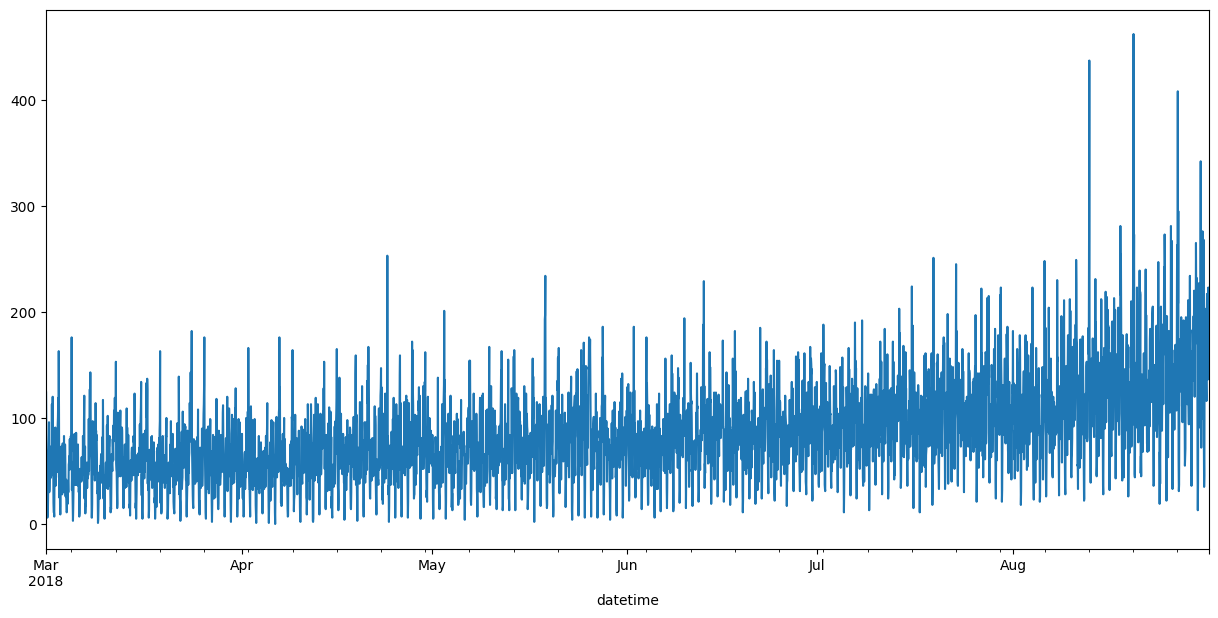

In [9]:
#вывожу график ресемплированных данных:
data['num_orders'].plot(figsize=(15,7))

Первичный график нечитабелен. Проведем ресемплирование по часам, найдем скользящее среднее.

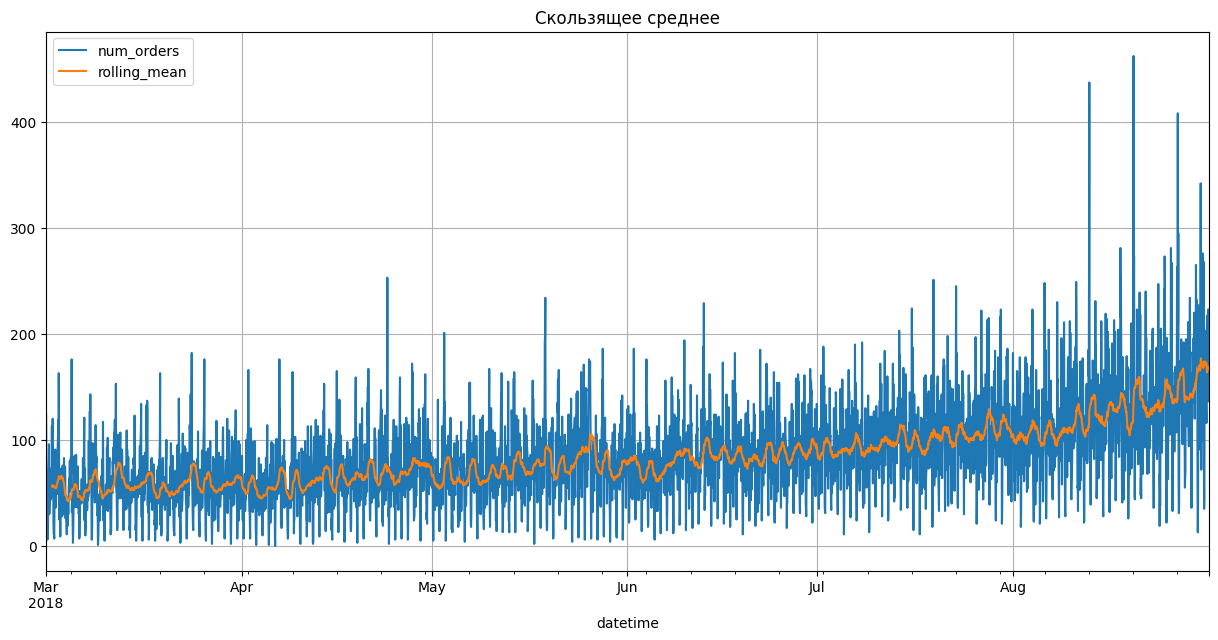

In [10]:
data['rolling_mean'] = data.rolling(24).mean()
data.plot(figsize=(15, 7))
plt.title('Скользящее среднее')
plt.grid()
plt.legend()
plt.show
data = data.drop('rolling_mean', axis = 1)

На графике (по скользящему среднему) мы можем наблюдать постоянные колебания количества заказов и постепенный их рост.

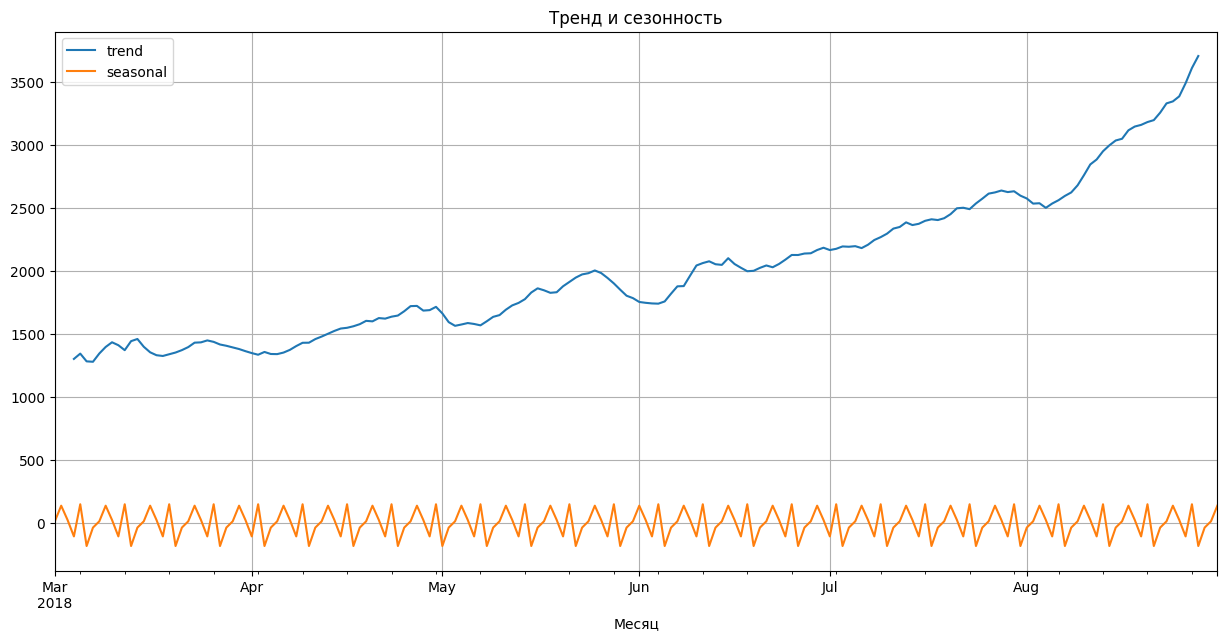

In [11]:
decomposed = seasonal_decompose(data.resample('1D').sum())
decomposed.trend.plot(figsize=(15, 7))
decomposed.seasonal.plot()
plt.legend()
plt.grid()
plt.title('Тренд и сезонность')
plt.xlabel('Месяц')
plt.show()

Со временем число заказов растет. Сезонность колеблется, посмотрим ее по дням недели:

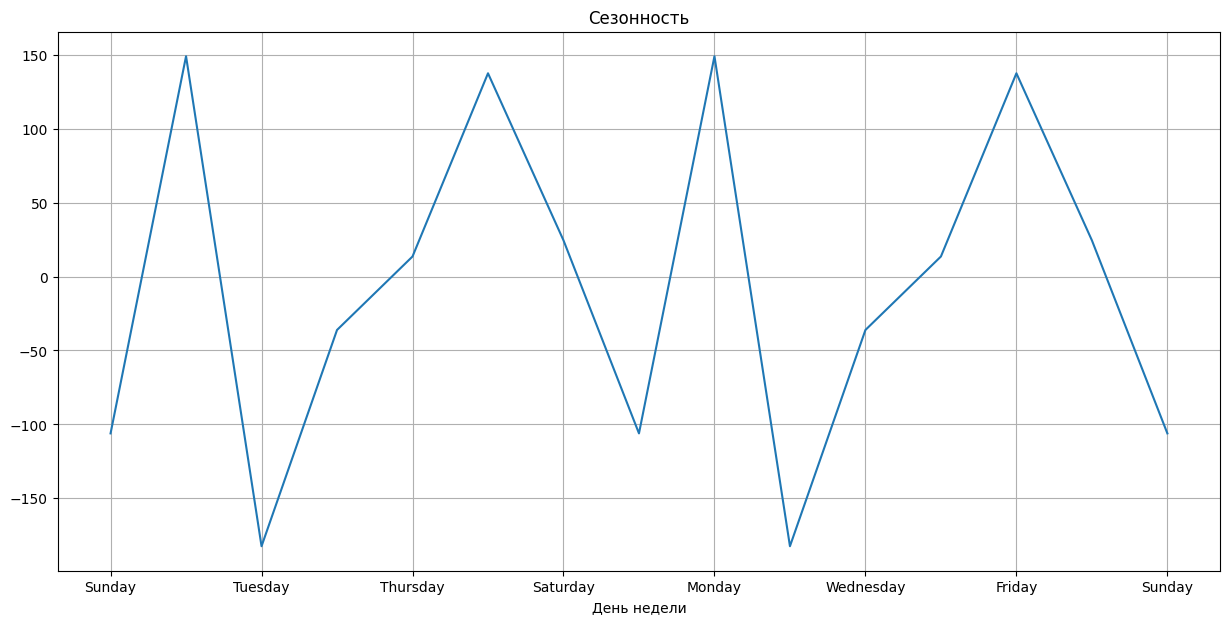

In [12]:
seasonal = decomposed.seasonal['2018-03-04':'2018-03-18']
seasonal.index = seasonal.index.day_name()
seasonal.plot(figsize=(15, 7))
plt.grid()
plt.title('Сезонность')
plt.xlabel('День недели')
plt.show()

<b> По данным графикам можно сделать вывод:</b>
* Присутствует восходящий тренд  и сезонность (кол-во заказов растет).
* Больше всего такси заказывают в понедельник и пятницу, на выходных и в остальные будни - меньше.

## Обучение моделей

<b> Создадим новые признаки: </b>
* час;
* день;
* месяц;
* день недели;
* разности временного ряда;
* скользящее среднее.

In [13]:
def get_futures():
    extra_data = data.copy()
    extra_data['hour'] = extra_data.index.hour
    extra_data['day'] = extra_data.index.day
    extra_data['month'] = extra_data.index.month
    extra_data['dayofweek'] = extra_data.index.dayofweek

    for shift in range(1, 11):
        extra_data['shift_{}'.format(shift)] = extra_data['num_orders'].shift(shift)

    extra_data['rolling_mean'] = extra_data['num_orders'].shift().rolling(10).mean()
    extra_data.dropna(inplace=True)
    return extra_data

In [14]:
extra_data = get_futures()

In [15]:
extra_data.head()

,num_orders,hour,day,month,dayofweek,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 10:00:00,64,10,1,3,3,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,52.5
2018-03-01 11:00:00,96,11,1,3,3,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,46.5
2018-03-01 12:00:00,30,12,1,3,3,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,47.6
2018-03-01 13:00:00,32,13,1,3,3,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,43.5
2018-03-01 14:00:00,48,14,1,3,3,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,40.1


In [16]:
features = extra_data.drop('num_orders', axis=1)
target = extra_data['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size = 0.1,
                                                                            shuffle = False)

In [17]:
features_train.shape, features_train.index.min(), features_train.index.max()

((3965, 15),
 Timestamp('2018-03-01 10:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'))

In [18]:
target_train.shape, target_train.index.min(), target_train.index.max()

((3965,),
 Timestamp('2018-03-01 10:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'))

In [19]:
features_test.shape, features_test.index.min(), features_test.index.max()

((441, 15),
 Timestamp('2018-08-13 15:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [20]:
target_test.shape, target_test.index.min(), target_test.index.max()

((441,),
 Timestamp('2018-08-13 15:00:00', freq='H'),
 Timestamp('2018-08-31 23:00:00', freq='H'))

In [21]:
tscv = TimeSeriesSplit(n_splits=5)

<b> CatBoostRegressor </b>

In [22]:
%%time
model_catboost = CatBoostRegressor(random_state=12345)

# Задаем сетку гиперпараметров для подбора
hyperparams = {
    'learning_rate': [0.1, 0.5, 0.8],
    'verbose': [True, False]
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator = model_catboost, param_grid = hyperparams, cv = tscv, scoring = 'neg_root_mean_squared_error')

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(features_train, target_train)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_catboost = CatBoostRegressor(**best_params)

# Обучаем модель с лучшими гиперпараметрами
best_model_catboost.fit(features_train, target_train)

# RMSE 
rmse_rf = grid_cv.best_score_ * -1

print("Лучшие гиперпараметры модели CatBoostRegressor : ", best_params)
print("RMSE CatBoostRegressor : %.2f" % rmse_rf)

0:	learn: 28.2992474	total: 146ms	remaining: 2m 26s
1:	learn: 27.1209955	total: 147ms	remaining: 1m 13s
2:	learn: 25.9357820	total: 148ms	remaining: 49.3s
3:	learn: 25.0293266	total: 150ms	remaining: 37.3s
4:	learn: 24.1078867	total: 151ms	remaining: 30s
5:	learn: 23.4537333	total: 152ms	remaining: 25.2s
6:	learn: 22.9734494	total: 153ms	remaining: 21.7s
7:	learn: 22.3839418	total: 154ms	remaining: 19.1s
8:	learn: 21.7492339	total: 155ms	remaining: 17.1s
9:	learn: 21.2882386	total: 156ms	remaining: 15.5s
10:	learn: 20.7444464	total: 157ms	remaining: 14.1s
11:	learn: 20.3148594	total: 158ms	remaining: 13s
12:	learn: 19.9422193	total: 159ms	remaining: 12.1s
13:	learn: 19.5787076	total: 161ms	remaining: 11.3s
14:	learn: 19.2139380	total: 162ms	remaining: 10.6s
15:	learn: 18.8873038	total: 163ms	remaining: 10s
16:	learn: 18.5461894	total: 164ms	remaining: 9.46s
17:	learn: 18.2946235	total: 165ms	remaining: 8.98s
18:	learn: 18.0835755	total: 166ms	remaining: 8.55s
19:	learn: 17.8494035	tota

<b> Случайный лес</b>

In [23]:
%%time
model_rf = RandomForestRegressor(random_state=STATE, n_jobs=-1)

# Задаем сетку гиперпараметров для подбора
hyperparams = {
    'n_estimators': range(50, 251, 50),
    'max_depth': range(2, 15)
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator = model_rf, param_grid = hyperparams, cv = tscv, scoring = 'neg_root_mean_squared_error')

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(features_train, target_train)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_rf = RandomForestRegressor(**best_params)

# Обучаем модель с лучшими гиперпараметрами
best_model_rf.fit(features_train, target_train)

# RMSE 
rmse_rf = grid_cv.best_score_ * -1

print("Лучшие гиперпараметры модели RandomForestRegressor: ", best_params)
print("RMSE RandomForestRegressor: %.2f" % rmse_rf)

Лучшие гиперпараметры модели RandomForestRegressor:  {'max_depth': 14, 'n_estimators': 250}
RMSE RandomForestRegressor: 25.22
CPU times: total: 1min 17s
Wall time: 1min 17s


<b>LGBMRegressor</b>

In [24]:
%%time

model_lgbm = LGBMRegressor(random_state=STATE, n_jobs=-1)

# Задаем сетку гиперпараметров для подбора
hyperparams = {
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [10, 50, 100, 500, 1000, 5000],
    'learning_rate': [.1, .3, .5]
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator = model_lgbm, param_grid = hyperparams, cv = tscv, scoring = 'neg_root_mean_squared_error')

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(features_train, target_train)

# Получаем лучшие гиперпараметры
best_params = grid_cv.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_lgbm = LGBMRegressor(**best_params)

# Обучаем модель с лучшими гиперпараметрами
best_model_lgbm.fit(features_train, target_train)

# Получаем предсказания
predict_lgbm = grid_cv.predict(features_train)

# Вычисление RMSE
rmse_lgb = grid_cv.best_score_ * -1
print("Лучшие гиперпараметры модели LightGBM: ", best_params)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)

Лучшие гиперпараметры модели LightGBM:  {'boosting_type': 'gbdt', 'learning_rate': 0.1, 'num_leaves': 10}
RMSE LightGBM на валидационной выборке: 25.09
CPU times: total: 5min 9s
Wall time: 23.3 s


<b> Промежуточный вывод:</b>
Лучшее значение метрики RMSE показала модель LightGBM, для проверки данных на тестовой выборке будем использовать её.

## Проверим данные на тестовой выборке

In [25]:
predict_test = best_model_lgbm.predict(features_test)
rmse_test = np.sqrt(mean_squared_error(target_test, predict_test))
print("RMSE LightGBM на тестовой выборке: %.2f" % rmse_test)

RMSE LightGBM на тестовой выборке: 43.42


Значение метрики RMSE на тестовой выборке не превышает требуемого значения 48

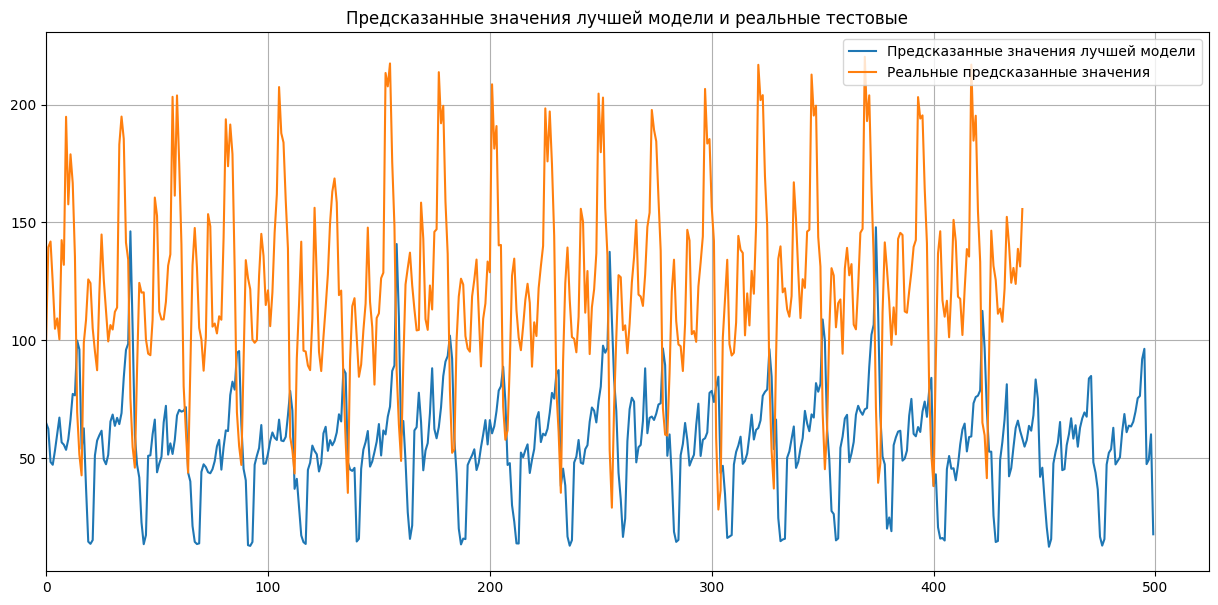

In [41]:
pd.Series(predict_lgbm)[:500].plot(figsize=(15, 7), label='Предсказанные значения лучшей модели', xlim = 0)
pd.Series(predict_test).plot(label='Реальные предсказанные значения')
plt.legend()
plt.grid()
plt.title('Предсказанные значения лучшей модели и реальные тестовые')
plt.show()

Из графика видно, что предсказания на реальных значениях, как и значение метрики RMSE, выше предсказаний на лучшей модели LightGBM примерно в два раза.

<b> Вывод: </b>
1. Данные загружены и изучены.
2. Выполнено ресемплирование по одному часу.
2. Данные были разделены на обучающую и тестовую (90/10) выборки.
3. Обучены следующие модели с подобранными гипперпараметрами:
    * LinearRegression;
    * RandomForestRegressor;
    * LightGBM;
4. Лучшее значение метрики RMSE (25.09) показала модель LightGBM, на проверке данных на тестовой выборке получили результат (43.42), не превышающий требуемого значения 48.